# Leer datasets

In [21]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)
wine = wine.frame
wine.drop(columns=['target'], inplace=True)
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


# Realizamos los clusters

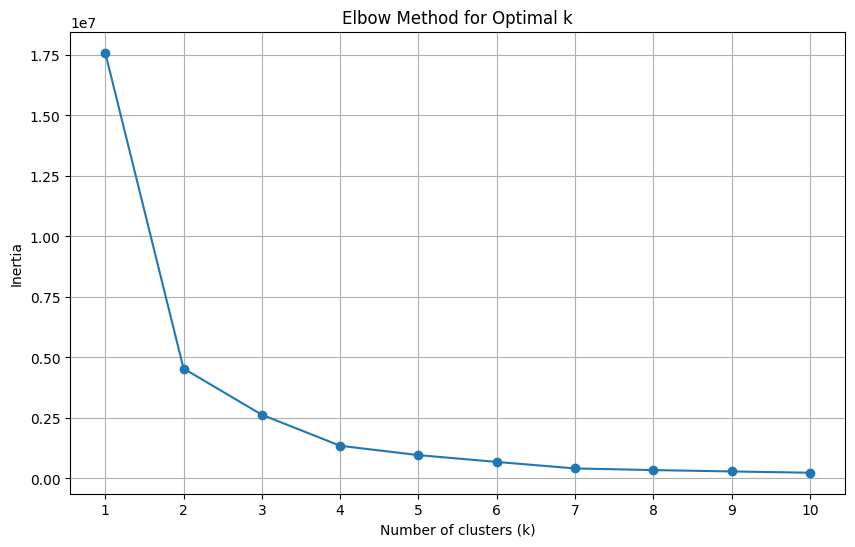

In [22]:
#hagamos metodo del codo para determinar el numero de clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def elbow_method(data, max_k=10):
    inertia = []
    k_values = range(1, max_k + 1)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertia, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_values)
    plt.grid()
    plt.show()
# Aplicar el método del codo
elbow_method(wine)

In [23]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(wine)
kmeans_labels = kmeans.labels_
aglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
aglo.fit(wine)
aglo_labels = aglo.labels_
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(wine)
gmm_labels = gmm.predict(wine)

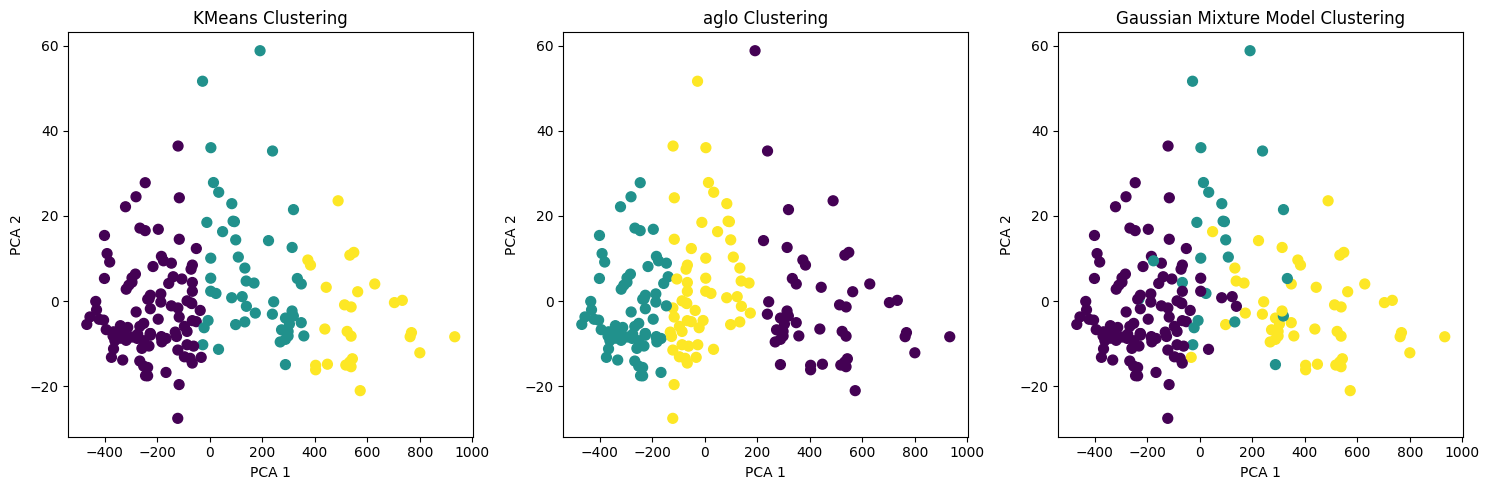

In [24]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Reducir a 2 dimensiones para visualización
pca = PCA(n_components=2)
wine_pca = pca.fit_transform(wine)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(wine_pca[:, 0], wine_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('KMeans Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 3, 2)
plt.scatter(wine_pca[:, 0], wine_pca[:, 1], c=aglo_labels, cmap='viridis', s=50)
plt.title('aglo Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 3, 3)
plt.scatter(wine_pca[:, 0], wine_pca[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import silhouette_score
kmeans_silhouette = silhouette_score(wine, kmeans_labels)
aglo_silhouette = silhouette_score(wine, aglo_labels)
gmm_silhouette = silhouette_score(wine, gmm_labels)
print(f'KMeans Silhouette Score: {kmeans_silhouette:.2f}')
print(f'aglo Silhouette Score: {aglo_silhouette:.2f}')
print(f'Gaussian Mixture Model Silhouette Score: {gmm_silhouette:.2f}')

KMeans Silhouette Score: 0.56
aglo Silhouette Score: 0.56
Gaussian Mixture Model Silhouette Score: 0.35


# Interpretar

In [26]:
import sys
sys.path.append('..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

## Kmeans

In [27]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(wine, kmeans_labels, test_size=0.2, random_state=42)


In [28]:
#muestrame los centros de los clusters
centers = kmeans.cluster_centers_
print("KMeans Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

KMeans Cluster Centers:
Cluster 0: [1.25985294e+01 2.45343137e+00 2.32186275e+00 2.06460784e+01
 9.36960784e+01 2.05362745e+00 1.64754902e+00 3.95980392e-01
 1.42509804e+00 4.67333332e+00 9.17843137e-01 2.39480392e+00
 5.21558824e+02]
Cluster 1: [1.33691837e+01 2.40000000e+00 2.39265306e+00 1.85142857e+01
 1.09081633e+02 2.44163265e+00 2.21367347e+00 3.25510204e-01
 1.70673469e+00 5.18836735e+00 9.59714286e-01 2.84795918e+00
 9.06346939e+02]
Cluster 2: [1.38507407e+01 1.77851852e+00 2.48777778e+00 1.69259259e+01
 1.05629630e+02 2.94148148e+00 3.13666667e+00 2.98888889e-01
 2.00703704e+00 6.27518519e+00 1.10296296e+00 3.00222222e+00
 1.30877778e+03]


In [29]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.86


In [30]:
r = ripper.get_rules()
string = str(r[0])
string1 = str(r[1])
rules = string.split('V')
rules1 = string1.split('V')
print("aglo Ripper Rules:", len(rules))
print("aglo Ripper Rules:", len(rules1))
ripper.print_rules()

aglo Ripper Rules: 8
aglo Ripper Rules: 5

Reglas para clase: 0
[[magnesium=<86.0] V [proline=594.0-660.0] V [proline=520.0-594.0] V [proline=410.5-473.6] V [proline=473.6-520.0] V [proline=<410.5] V [proline=660.0-723.0^alcohol=13.22-13.49] V [proline=660.0-723.0^flavanoids=0.61-0.83]]

Reglas para clase: 1
[[proline=723.0-865.5] V [proline=865.5-1032.0] V [proline=1032.0-1194.5^flavanoids=2.68-2.98] V [proline=1032.0-1194.5^total_phenols=2.31-2.5] V [nonflavanoid_phenols=0.26-0.28^alcohol=>14.1]]

Reglas para clase: 2
[[proline=>1194.5] V [flavanoids=>3.24^proline=1032.0-1194.5]]


Decision Tree Accuracy: 1.00


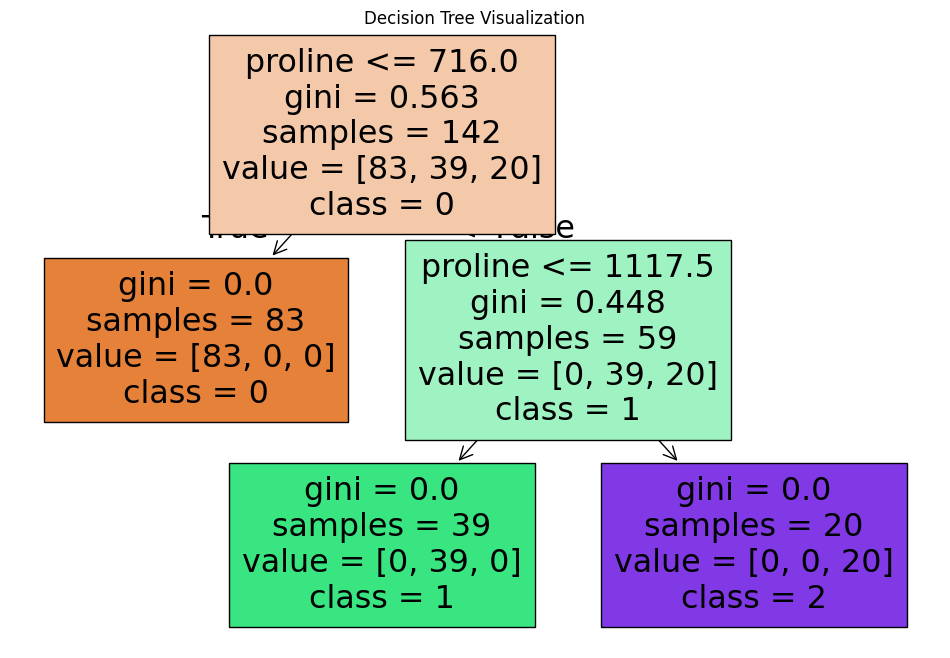

In [31]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=wine.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [32]:
ds = DSClassifierMultiQ(n_clusters, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=wine.columns.tolist())


Optimization started

Training time: 5.88s, epochs: 200

Least training loss reached: 0.035


In [33]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.727] R8: ash < 2.173
			0: 0.572	1: 0.351	2: 0.000	Unc: 0.077

	[0.680] R48: proline < 531.699
			0: 0.680	1: 0.000	2: 0.000	Unc: 0.320

	[0.603] R49: 531.699 < proline < 734.894
			0: 0.603	1: 0.000	2: 0.000	Unc: 0.397

	[0.590] R34: 1.608 < proanthocyanins < 2.000
			0: 0.473	1: 0.262	2: 0.000	Unc: 0.264

	[0.561] R15: alcalinity_of_ash > 21.795
			0: 0.423	1: 0.320	2: 0.000	Unc: 0.257

	[0.540] R41: 0.799 < hue < 0.956
			0: 0.538	1: 0.004	2: 0.000	Unc: 0.459

	[0.530] R28: nonflavanoid_phenols < 0.282
			0: 0.437	1: 0.204	2: 0.000	Unc: 0.359

	[0.514] R37: 3.491 < color_intensity < 5.058
			0: 0.352	1: 0.399	2: 0.000	Unc: 0.249

	[0.475] R16: magnesium < 90.597
			0: 0.475	1: 0.000	2: 0.000	Unc: 0.525

	[0.445] R24: flavanoids < 1.327
			0: 0.270	1: 0.462	2: 0.000	Unc: 0.268

	[0.444] R6: 2.374 < malic_acid < 3.142
			0: 0.340	1: 0.240	2: 0.000	Unc: 0.420

	[0.439] R31: nonflavanoid_phenols > 0.454
			0: 0.337	1: 0.236	2: 0.000	Unc: 0.427

	[

In [34]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.83


## aglo

In [35]:
#dividir los datos en entrenamiento y prueba
n_clusters_aglo = len(np.unique(aglo_labels))
max_label = np.max(aglo_labels)
aglo_labels = np.where(aglo_labels == -1, max_label + 1, aglo_labels)  # Assign a new label for noise points
X_train, X_test, y_train, y_test = train_test_split(wine, aglo_labels, test_size=0.2, random_state=42)


In [36]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.97


In [37]:
r = ripper.get_rules()
string = str(r[0])
string1 = str(r[1])
rules = string.split('V')
rules1 = string1.split('V')
print("aglo Ripper Rules:", len(rules))
print("aglo Ripper Rules:", len(rules1))
ripper.print_rules()

aglo Ripper Rules: 4
aglo Ripper Rules: 4

Reglas para clase: 0
[[proline=1032.0-1194.5] V [proline=>1194.5] V [proline=865.5-1032.0^malic_acid=1.67-1.73] V [total_phenols=2.31-2.5^proline=865.5-1032.0]]

Reglas para clase: 1
[[proline=473.6-520.0] V [proline=<410.5] V [proline=410.5-473.6] V [proline=520.0-594.0]]

Reglas para clase: 2
[[proline=660.0-723.0] V [proline=723.0-865.5] V [proline=594.0-660.0] V [proline=865.5-1032.0^magnesium=105.0-111.0]]


Decision Tree Accuracy: 1.00


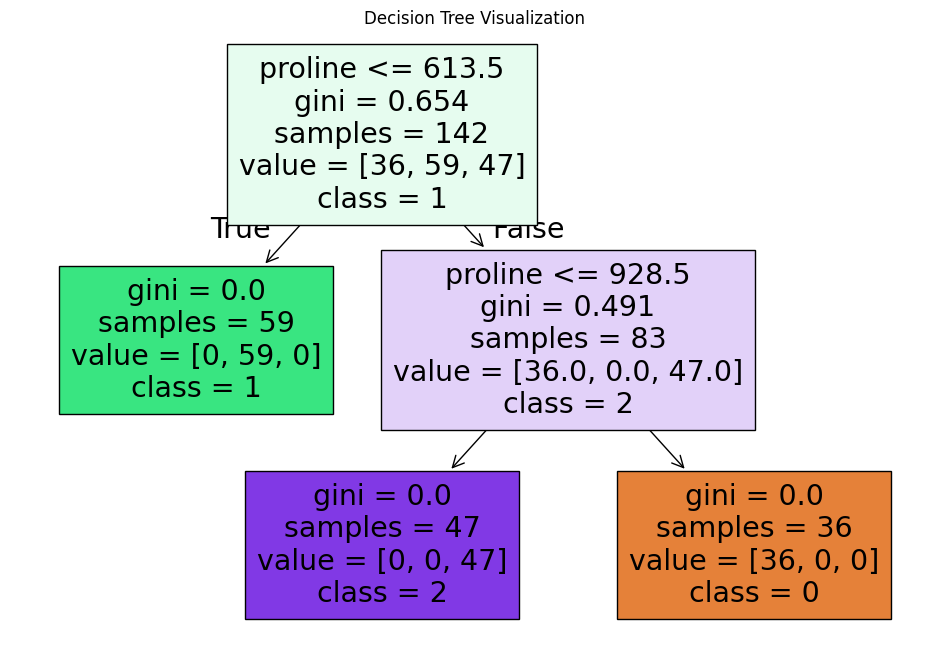

In [38]:
tree = DecisionTreeClassifier(random_state=44, min_samples_leaf=5)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=wine.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [39]:
ds = DSClassifierMultiQ(n_clusters_aglo, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=wine.columns.tolist())


Optimization started

Training time: 5.69s, epochs: 200

Least training loss reached: 0.030


In [40]:
ds.print_most_important_rules(threshold=0.001)



Most important rules for class 0

	[0.763] R39: color_intensity > 6.624
			0: 0.623	1: 0.000	2: 0.310	Unc: 0.066

	[0.677] R51: proline > 938.089
			0: 0.677	1: 0.000	2: 0.000	Unc: 0.323

	[0.676] R43: hue > 1.114
			0: 0.624	1: 0.108	2: 0.000	Unc: 0.268

	[0.593] R17: 90.597 < magnesium < 100.444
			0: 0.581	1: 0.000	2: 0.024	Unc: 0.395

	[0.566] R19: magnesium > 110.291
			0: 0.435	1: 0.019	2: 0.283	Unc: 0.264

	[0.537] R18: 100.444 < magnesium < 110.291
			0: 0.408	1: 0.002	2: 0.295	Unc: 0.295

	[0.525] R26: 2.002 < flavanoids < 2.677
			0: 0.359	1: 0.410	2: 0.000	Unc: 0.231

	[0.491] R3: alcohol > 13.530
			0: 0.459	1: 0.066	2: 0.000	Unc: 0.475

	[0.472] R42: 0.956 < hue < 1.114
			0: 0.356	1: 0.017	2: 0.254	Unc: 0.374

	[0.461] R22: 2.289 < total_phenols < 2.718
			0: 0.443	1: 0.037	2: 0.000	Unc: 0.520

	[0.443] R12: alcalinity_of_ash < 17.151
			0: 0.271	1: 0.000	2: 0.453	Unc: 0.276

	[0.437] R5: 1.605 < malic_acid < 2.374
			0: 0.308	1: 0.000	2: 0.313	Unc: 0.379

	[0.430] R28:

In [41]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.81


## GMM

In [42]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(wine, gmm_labels, test_size=0.2, random_state=42)


In [43]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.83


In [44]:
r = ripper.get_rules()
string = str(r[0])
string1 = str(r[1])
rules = string.split('V')
rules1 = string1.split('V')
print("aglo Ripper Rules:", len(rules))
print("aglo Ripper Rules:", len(rules1))
ripper.print_rules()

aglo Ripper Rules: 9
aglo Ripper Rules: 2

Reglas para clase: 0
[[magnesium=<86.0] V [proline=594.0-660.0] V [magnesium=86.0-88.0] V [proline=520.0-594.0] V [proline=473.6-520.0] V [proline=410.5-473.6] V [proline=<410.5] V [proline=660.0-723.0] V [color_intensity=2.94-3.4^alcalinity_of_ash=20.0-21.0]]

Reglas para clase: 1
[[proline=723.0-865.5] V [malic_acid=3.43-4.09^ash=2.25-2.3]]

Reglas para clase: 2
[[proline=>1194.5] V [flavanoids=2.68-2.98^proline=1032.0-1194.5] V [proline=865.5-1032.0^malic_acid=1.73-1.88] V [proline=1032.0-1194.5^flavanoids=>3.24] V [proline=865.5-1032.0^od280/od315_of_diluted_wines=3.25-3.44] V [hue=1.08-1.16^flavanoids=2.42-2.68]]


Decision Tree Accuracy: 0.89


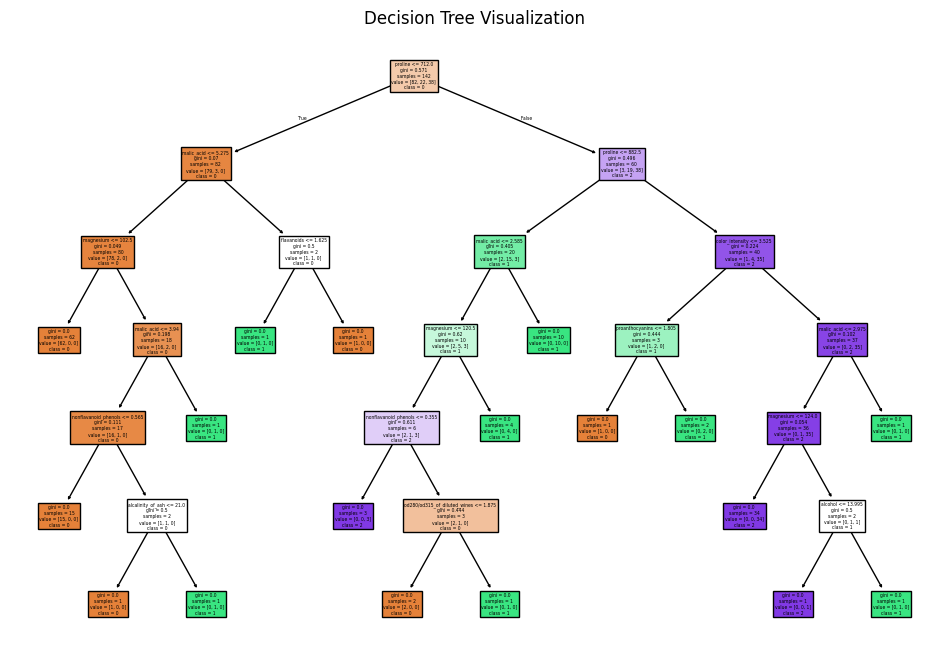

In [45]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=wine.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [46]:
ds = DSClassifierMultiQ(n_clusters, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=wine.columns.tolist())


Optimization started

Training time: 5.71s, epochs: 200

Least training loss reached: 0.025


In [47]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.669] R15: alcalinity_of_ash > 21.795
			0: 0.476	1: 0.465	2: 0.000	Unc: 0.059

	[0.593] R48: proline < 531.699
			0: 0.593	1: 0.000	2: 0.000	Unc: 0.407

	[0.582] R30: 0.368 < nonflavanoid_phenols < 0.454
			0: 0.530	1: 0.000	2: 0.109	Unc: 0.361

	[0.551] R41: 0.799 < hue < 0.956
			0: 0.359	1: 0.000	2: 0.484	Unc: 0.156

	[0.548] R8: ash < 2.173
			0: 0.548	1: 0.000	2: 0.000	Unc: 0.452

	[0.535] R6: 2.374 < malic_acid < 3.142
			0: 0.445	1: 0.198	2: 0.000	Unc: 0.357

	[0.529] R42: 0.956 < hue < 1.114
			0: 0.360	1: 0.418	2: 0.000	Unc: 0.222

	[0.517] R0: alcohol < 12.428
			0: 0.475	1: 0.087	2: 0.000	Unc: 0.438

	[0.495] R49: 531.699 < proline < 734.894
			0: 0.489	1: 0.000	2: 0.012	Unc: 0.499

	[0.493] R18: 100.444 < magnesium < 110.291
			0: 0.357	1: 0.000	2: 0.324	Unc: 0.319

	[0.493] R25: 1.327 < flavanoids < 2.002
			0: 0.493	1: 0.000	2: 0.000	Unc: 0.507

	[0.488] R36: color_intensity < 3.491
			0: 0.398	1: 0.201	2: 0.000	Unc: 0.401

	[0.473]

In [48]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.89
